<a href="https://colab.research.google.com/github/jwells52/creating-ai-enabled-systems/blob/main/Research%20Project/notebooks/fsl_experiment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install easyfsl

In [1]:
%pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 1.3 MB/s eta 0:00:00


### Download Humpback Whale Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/Research-Project/kaggle.json /root/.kaggle/kaggle.json && chmod 600 /root/.kaggle/kaggle.json && kaggle competitions download -c humpback-whale-identification

100% 5.50G/5.51G [03:18<00:00, 37.6MB/s]
100% 5.51G/5.51G [03:18<00:00, 29.8MB/s]


In [1]:
%%capture

!unzip humpback-whale-identification.zip

### Clone GitHub Repo

In [1]:
import os

if os.path.exists('/content/creating-ai-enabled-systems/Research Project') == False:
  !git clone https://github.com/jwells52/creating-ai-enabled-systems.git

%cd creating-ai-enabled-systems/Research\ Project

/content/creating-ai-enabled-systems/Research Project


### Imports

In [2]:
import os
import cv2
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from easyfsl.methods import PrototypicalNetworks, FewShotClassifier, SimpleShot
from easyfsl.utils import evaluate, evaluate_on_one_task
from easyfsl.samplers import TaskSampler

from torch import Tensor, nn
from torch.optim import SGD, Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34, resnet152

from typing import Callable

from modules.data_utils import HumpbackWhaleDataset, remove_new_whale_class, create_loaders
from modules.train import train_fsl, device, transform


%load_ext autoreload
%autoreload 2

In [15]:
n_way   = 25
n_shot  = 3
n_query = 5

### Look at classes that have low performance

In [16]:
# Load into dataset
# For each class, calculate accuracy
# Then plot barplot of accuracy for each class
# Look at the characteristics of images for the classes that have low performance

In [17]:
df = remove_new_whale_class(
  pd.read_csv('/content/creating-ai-enabled-systems/Research Project/data/validation_10samples.csv')
)


# df = df[df['class_count'] > 15]

In [18]:
dataset = HumpbackWhaleDataset('/content/train', df, transform=transform)

In [19]:
sampler = TaskSampler(
    dataset, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=30
)

In [20]:
loader = DataLoader(
    dataset,
    batch_sampler=sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=sampler.episodic_collate_fn
)


In [9]:
cnn = resnet34()
cnn.fc = torch.nn.Flatten()
few_shot_classifier = PrototypicalNetworks(cnn).to(device)
few_shot_classifier.load_state_dict(
  torch.load('/content/drive/MyDrive/prototypical_network_resnet18_last_epoch')()
)

<All keys matched successfully>

In [10]:
%%capture

few_shot_classifier.eval()

In [11]:
class_accs = dict()
for (
    support_images,
    support_labels,
    query_images,
    query_labels,
    _,) in loader:

    few_shot_classifier.process_support_set(support_images.to(device), support_labels.to(device))
    predictions = few_shot_classifier(query_images.to(device)).detach().data
    prediction_labels = torch.max(predictions, 1)[1].cpu().detach().data
    for label in torch.unique(query_labels):
      label_idxs = torch.argwhere(query_labels == label)
      whale_id = dataset.id_to_label[label.detach().item()]
      whale_id_acc = (prediction_labels[label_idxs] == query_labels[label_idxs]).sum().item() / 5
      print(f'{whale_id} | acc = {whale_id_acc}')

      if whale_id not in class_accs:
        class_accs[whale_id] = [whale_id_acc]
      else:
        class_accs[whale_id] += [whale_id_acc]

w_a8b34a0 | acc = 0.8
w_2df85e7 | acc = 1.0
w_fccccec | acc = 1.0
w_6f0cbe3 | acc = 1.0
w_6e209a8 | acc = 1.0
w_40a8585 | acc = 1.0
w_4846b27 | acc = 1.0
w_51e7506 | acc = 0.8
w_234713b | acc = 0.6
w_27b7295 | acc = 0.6
w_5d5c6a6 | acc = 1.0
w_8b86b95 | acc = 1.0
w_fdd3687 | acc = 1.0
w_4bf625b | acc = 1.0
w_2b65b34 | acc = 0.6
w_f829227 | acc = 1.0
w_e906edd | acc = 1.0
w_aabdf8c | acc = 1.0
w_0fdf741 | acc = 1.0
w_3eae264 | acc = 1.0
w_a8b34a0 | acc = 0.6
w_2df85e7 | acc = 1.0
w_fccccec | acc = 0.8
w_6f0cbe3 | acc = 0.8
w_6e209a8 | acc = 1.0
w_40a8585 | acc = 0.6
w_4846b27 | acc = 1.0
w_51e7506 | acc = 0.4
w_234713b | acc = 1.0
w_27b7295 | acc = 0.8
w_5d5c6a6 | acc = 0.8
w_8b86b95 | acc = 1.0
w_fdd3687 | acc = 1.0
w_4bf625b | acc = 0.4
w_2b65b34 | acc = 0.8
w_f829227 | acc = 1.0
w_e906edd | acc = 0.2
w_aabdf8c | acc = 1.0
w_0fdf741 | acc = 1.0
w_3eae264 | acc = 1.0
w_a8b34a0 | acc = 1.0
w_2df85e7 | acc = 0.8
w_fccccec | acc = 1.0
w_6f0cbe3 | acc = 0.8
w_6e209a8 | acc = 0.6
w_40a8585 

In [12]:
class_acc_means = dict()
for k, v in class_accs.items():
  class_acc_means[k] = np.mean(v)

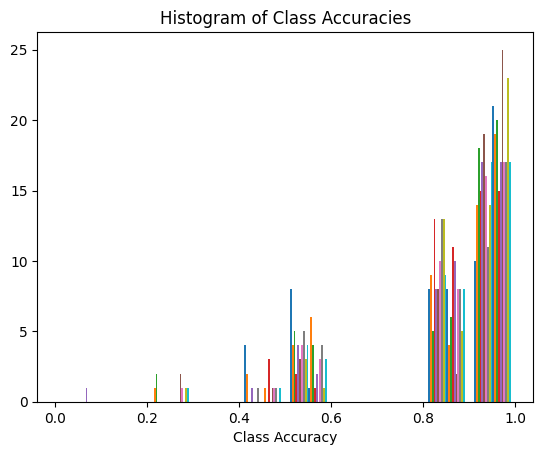

In [13]:
plt.title('Histogram of Class Accuracies')
plt.hist(class_accs.values())
plt.xlabel('Class Accuracy');

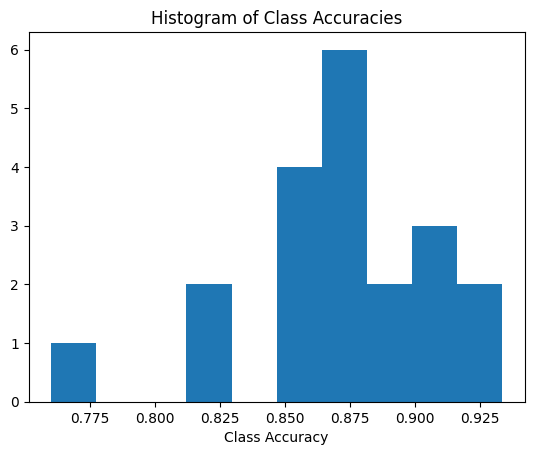

In [14]:
plt.title('Histogram of Class Accuracies')
plt.hist(class_acc_means.values())
plt.xlabel('Class Accuracy');

In [ ]:
|